In [ ]:
# Importing libraries
import pandas as pd
from preprocessing_utils import prepare_dataset
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from dataset import CheXpertDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
from training_utils import train_model, upload_pretrained, upload_pretrained_vit
from torchsummary import summary
import torchvision.models as models
from tqdm.notebook import tqdm
import pickle

In [2]:
# Enable the widgets extension for JupyterLab
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
C:\Users\bar24\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
C:\Users\bar24\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
C:\Users\bar24\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:56: UserWarning: See the log file for details: C:\Users\bar24\AppData\Local\Temp\jupyterlab-debug-gic2v8tw.log
  warnings.warn(f"See the 

#### Constructing training dataset

In [3]:
# Import the train dataset
train_df = pd.read_csv('CheXpert-v1.0-small/train.csv')

# Define the class names for the medical conditions
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

# Define the policies for dataset preparation
policies = ['ones', 'zeroes', 'mixed']

# Prepare the dataset using the last policy in the list and the defined class names
image_paths, label_matrix = prepare_dataset(train_df, policies[-1], class_names)

# Create a DataFrame for the image paths
image_paths_df = pd.DataFrame({'path': image_paths})

# Create a DataFrame for the labels with the class names as columns
labels_df = pd.DataFrame(label_matrix, columns=class_names)

# Combine the image paths DataFrame and the labels DataFrame
train_df = pd.concat([image_paths_df, labels_df], axis=1)

In [4]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
display(train_df.head())
print("Number of rows and columns in the train DataFrame:", train_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(train_df.dtypes)

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
0,CheXpert-v1.0-small/train/patient14619/study6/...,0,0,0,0,1
1,CheXpert-v1.0-small/train/patient14869/study2/...,0,0,0,1,0
2,CheXpert-v1.0-small/train/patient40881/study1/...,1,0,0,0,0
3,CheXpert-v1.0-small/train/patient24862/study3/...,0,0,0,0,1
4,CheXpert-v1.0-small/train/patient35268/study4/...,0,1,0,1,0


Number of rows and columns in the train DataFrame: (191027, 6)
Column names and data types:
path                object
Atelectasis          int32
Cardiomegaly         int32
Consolidation        int32
Edema                int32
Pleural Effusion     int32
dtype: object


#### Constructing validation dataset

In [5]:
# Import the validation dataset
valid_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

# Define the class names for the medical conditions
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

# Define the policies for dataset preparation
policies = ['ones', 'zeroes', 'mixed']

# Prepare the validation dataset using the last policy in the list and the defined class names
valid_image_paths, valid_label_matrix = prepare_dataset(valid_df, policies[-1], class_names)

# Create a DataFrame for the validation image paths
valid_image_paths_df = pd.DataFrame({'path': valid_image_paths})

# Create a DataFrame for the validation labels with the class names as columns
valid_labels_df = pd.DataFrame(valid_label_matrix, columns=class_names)

# Combine the validation image paths DataFrame and the validation labels DataFrame
valid_df = pd.concat([valid_image_paths_df, valid_labels_df], axis=1)

In [6]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
display(valid_df.head())
print("Number of rows and columns in the validation DataFrame:", valid_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(valid_df.dtypes)

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
0,CheXpert-v1.0-small/valid/patient64735/study1/...,1,0,0,0,0
1,CheXpert-v1.0-small/valid/patient64634/study1/...,0,0,0,0,0
2,CheXpert-v1.0-small/valid/patient64712/study1/...,0,1,0,1,0
3,CheXpert-v1.0-small/valid/patient64662/study1/...,0,0,0,0,0
4,CheXpert-v1.0-small/valid/patient64578/study1/...,0,0,0,0,0


Number of rows and columns in the validation DataFrame: (202, 6)
Column names and data types:
path                object
Atelectasis          int32
Cardiomegaly         int32
Consolidation        int32
Edema                int32
Pleural Effusion     int32
dtype: object


#### Dataset formation according to torch (using dataloaders)

In [7]:
# Define the transformation pipeline for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

# Define the class names for the medical conditions
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

# Create the training dataset with the defined transformations
train_dataset = CheXpertDataset(train_df, class_names, transform=transform)

# Create the validation dataset with the defined transformations
valid_dataset = CheXpertDataset(valid_df, class_names, transform=transform)

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for the validation dataset
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Verify data loading by fetching a batch of images and labels from the training DataLoader
images, labels = next(iter(train_loader))

#### Visualising example

In [8]:
# Fetch a batch of images and labels from the validation DataLoader
# test_X contains the images and test_Y contains the
# corresponding labels from the validation set
test_X, test_Y = next(iter(valid_loader))

Original shape: torch.Size([3, 224, 224]), New shape: (224, 224, 3)
Example image:


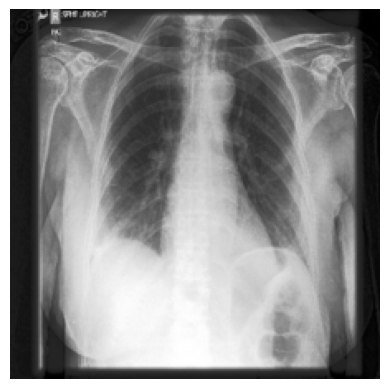

In [9]:
# Select the first image in the batch
image = test_X[0]
original_shape = image.shape
image = image.permute(1, 2, 0).numpy()  # Change shape to (224, 224, 3)
new_shape = image.shape
print(f"Original shape: {original_shape}, New shape: {new_shape}")
# Check the shape of the image to ensure it is (224, 224, 3)
assert new_shape == (224, 224, 3), f"Expected shape (224, 224, 3), but got {image.shape}"

# Denormalize the image for visualization
image = (image * 0.5) + 0.5

# Plot the image
print("Example image:")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

#### Here we can extract different pre-trained models (in the given example, Resnet18 and vision transformer).

In [10]:
# Load a pre-trained ResNet-18 model, add custom layers, and freeze certain layers
# 
# Parameters:
# - pretrained: Use a pre-trained version of ResNet-18
# - add_layers: Add custom layers to the model
# - n_labels: Number of output labels (classes)
# - freeze_layers: Freeze the layers of the pre-trained model to prevent them from being updated during training
model_resnet = upload_pretrained(
    models.resnet18(pretrained=True),  # Load a pre-trained ResNet-18 model
    add_layers=True,                   # Add custom layers to the model
    n_labels=5,                        # Set the number of output labels (classes) to 5
    freeze_layers=True                 # Freeze the layers of the pre-trained model
)

c:\Users\bar24\anaconda3\envs\ExplainableAI\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bar24\anaconda3\envs\ExplainableAI\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##### Moreover, we can see summary of a model

In [11]:
# Get a model summary for ViT with input size (1, 3, 384, 384)
summary(model_resnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### Here is how we train the model

In [ ]:
# Define the loss function
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
# Adam optimizer with learning rate of 0.001
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)

# Train the model
# Parameters:
# - model: The model to be trained (ResNet-18 in this case)
# - train_loader: DataLoader for the training dataset
# - test_loader: DataLoader for the validation dataset
# - criterion: The loss function
# - optimizer: The optimizer
# - num_epochs: Number of epochs to train the model
# - device: Device to train the model on ('cpu' or 'cuda')
# - save_filename: Filename to save the trained model
train_losses_resnet, train_accuracies_resnet, test_losses_resnet, test_accuracies_resnet = train_model(
    model=model_resnet,
    train_loader=train_loader,
    test_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer_resnet,
    num_epochs=20,
    device='cpu',
    save_filename='model_resnet.pth'
)

Epoch 1/20:   0%|          | 0/5970 [00:00<?, ?batch/s]

### Pickle the trained model

In [ ]:
# Save the trained model using pickle
with open('model_resnet.pkl', 'wb') as f:
    pickle.dump(model_resnet, f)

print("Model saved as model_resnet.pkl")

### Load the trained model

In [ ]:
with open('model_resnet.pkl', 'rb') as f:
    loaded_model_resnet = pickle.load(f)

print("Model loaded from model_resnet.pkl")